In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os, cv2
from tqdm import tqdm
import tensorflow as tf
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15779426955490509233,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6269894656
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7113605194545820014
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5"]

In [3]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

이미지 확인

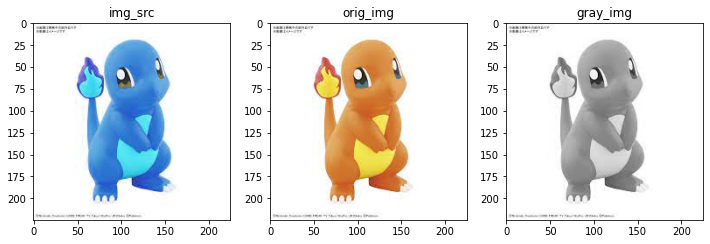

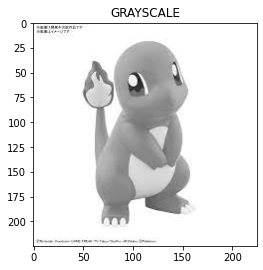

In [4]:
img_path = "C:/workspace/04.SecondProject/images"
img_cha = "pie"
img_src = cv2.imread(f"{img_path}/{img_cha}/{img_cha} (1).jpg", cv2.IMREAD_COLOR)
orig_img = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,8))
plt.subplot(1,3,3)
plt.title("gray_img")
plt.imshow(gray_img, cmap='gray')
plt.subplot(1,3,2)
plt.title("orig_img")
plt.imshow(orig_img)
plt.subplot(1,3,1)
plt.title("img_src")
plt.imshow(img_src)

plt.figure(figsize=(4,8))
plt.title("GRAYSCALE")
img = cv2.imread(f"{img_path}/{img_cha}/{img_cha} (1).jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [5]:
cha_list = ['isang', 'jammanbo', 'evee', 'pie', 'squirtle', 'pikachu', 'jiwoo', 'leeseul']
X = []
y = []
err = []

for idx, img_cha in enumerate(tqdm(cha_list)):
    filepath = f"{img_path}/{img_cha}"
    for fname in os.listdir(filepath):
        img = cv2.imread(f'{filepath}/{fname}', cv2.IMREAD_COLOR)
        try:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resize_img = cv2.resize(gray_img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)
            X.append(resize_img / 256)
            y.append(idx)

        except:
            err.append(fname)
            continue
        
X = np.array(X)
y = np.array(y)

print('\n에러:','None' if len(err) == 0 else err)

100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


에러: None


In [6]:
X.shape, y.shape

((4000, 128, 128), (4000,))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = seed
)

# X_train, X_valid, Y_train, Y_valid = train_test_split(
#     X_train, y_train, stratify = y_train, test_size = 0.2, random_state = seed
# )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3200, 128, 128), (800, 128, 128), (3200,), (800,))

In [9]:
# X_train, X_test 정규화 (0 ~ 1), 이미지 차원 변경: 2차원 --> 3차원
X_train = X_train.reshape(-1, 128, 128, 1) / 255.
X_test = X_test.reshape(-1, 128, 128, 1) / 255.
X_train.shape, X_test.shape

((3200, 128, 128, 1), (800, 128, 128, 1))

In [10]:
# y_data: one-hot encoding
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((3200, 8), (800, 8))

In [12]:
with tf.device("/device:CPU:0"):
    model = Sequential([
    Conv2D(32, (3, 3), input_shape = X_train.shape[1:], padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation = 'softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 64)       

In [13]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path = './gray_adam.h5'
mc = ModelCheckpoint(model_path, moniter = 'val_loss', verbose = 1, save_best_only = True)
es = EarlyStopping(patience = 15)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,          # randomly rotate images in the range 15 degree
    width_shift_range=0.1,      # randomly shift images horizontally 
    height_shift_range=0.1,     # randomly shift images vertically
    shear_range=0.1,            # 도형의 기울기
    zoom_range=[0.8,1.2],       # 0.8~1.2 배 크기로 임의로 확대/축소
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # randomly flip images
    fill_mode='nearest'         # set mode for filling points outside the input boundaries
)


In [16]:
datagen.fit(X_train)

In [17]:
with tf.device("/device:GPU:0"):
    hist1 = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_valid, Y_valid), epochs = 100, callbacks=[mc, es]
    )   

Epoch 1/100
80/80 [==============================] - 9s 57ms/step - loss: 2.0804 - accuracy: 0.1113 - val_loss: 2.0794 - val_accuracy: 0.1250

Epoch 00001: val_loss improved from inf to 2.07945, saving model to .\gray_adam.h5
Epoch 2/100
80/80 [==============================] - 5s 56ms/step - loss: 2.0797 - accuracy: 0.1242 - val_loss: 2.0795 - val_accuracy: 0.1250

Epoch 00002: val_loss did not improve from 2.07945
Epoch 3/100
80/80 [==============================] - 4s 55ms/step - loss: 2.0798 - accuracy: 0.1078 - val_loss: 2.0795 - val_accuracy: 0.1250

Epoch 00003: val_loss did not improve from 2.07945
Epoch 4/100
80/80 [==============================] - 5s 57ms/step - loss: 2.0797 - accuracy: 0.1281 - val_loss: 2.0794 - val_accuracy: 0.1250

Epoch 00004: val_loss did not improve from 2.07945
Epoch 5/100
80/80 [==============================] - 5s 56ms/step - loss: 2.0798 - accuracy: 0.1152 - val_loss: 2.0795 - val_accuracy: 0.1250

Epoch 00005: val_loss did not improve from 2.0794

In [18]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

25/25 [==============================] - 0s 7ms/step - loss: 2.0794 - accuracy: 0.1250


[2.079442024230957, 0.125]

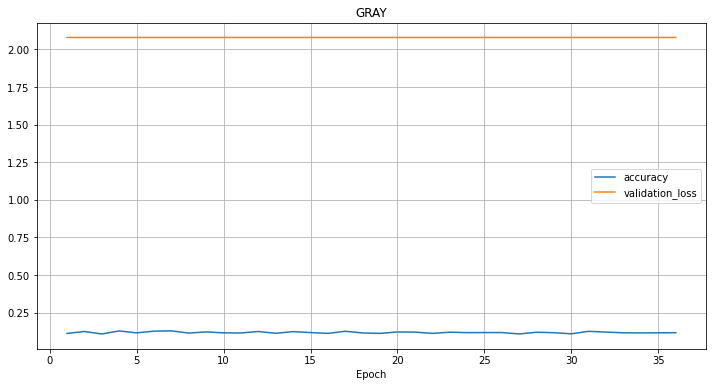

In [23]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('GRAY')
plt.legend(), plt.grid()
plt.show()